<img align="center" style="max-width: 1000px" src="https://github.com/HSG-AIML/IGARSS2023_EfficientDeepLearningEO/blob/main/04-ssl/banner.png?raw=1">

<img align='right' style='max-width: 200px; height: auto' src='https://drive.google.com/uc?id=1SQLib5liCBGXNLdWT0iYhHxUC1YVnx1_'>



# IGARSS Tutorial *Data-efficient Deep Learning for Earth Observation* 2023

## Lab - "Self-supervised Learning"

*Michael Mommert, Joelle Hanna, Linus Scheibenreif, Damian Borth*




This session will implement some of the self-supervised learning approaches for Earth Observation data that have been presented so far.

## Content

1. [Introduction](#introduction)
2. [Goals](#goals)
3. [Dataset](#dataset)
4. [Hand-crafted pre-text tasks](#pretext)
5. [Contrastive Learning](#contrast)
6. [Multi-modal Contrast](#multi-modal)
7. [Masked Autoencoding](#mae)
8. [Conclusion](#conclusion)

<a id='introduction'></a>
# Introduction
Self-supervised learning aims to learn meaningful representations in an unsupervised way. Earth observation and remote sensing data is an ideal setting for such methods, since large amounts of unlabeled data are routinely collected by sensors around the world. Labeled datasets on the other hand remain scarce for many important applications. Our goal is to leverage the troves of unlabeled data for the training of deep neural networks to create models than can then be transferred to applications with too little labeled data to train the models from scratch.

<a id='goals'></a>
# Goals
* Get familiar with common self-superivised learning objectives
* Learn how to train self-supervised models
* Adapt pre-trained models for downstream tasks of interest

<a id='dataset'></a>
# Dataset - BENGE
* We will again use BENGE
* Please revisit the multi-task learning notebook from the morning session for instructions on how to recreate the dataset on your machine.

In [1]:
# install required libraries
!pip install albumentations einops folium rasterio pytorch_lightning torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.4/722.4 kB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 53.5 MB/s eta 0:00:00


In [2]:
# system level modules for handling files and file structures
import os
import tarfile
import copy
import random
from collections import defaultdict

# scipy ecosystem imports for numerics, data handling and plotting
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

# pytorch and helper modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader, RandomSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback
import torchmetrics
from torchmetrics import Accuracy

# fast image augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# rasterio for reading in satellite image data
import rasterio as rio
from rasterio.enums import Resampling

# map visualization
import folium

# progress bar
from tqdm import tqdm


folium_colors = ['red', 'blue', 'gray', 'darkred', 'lightred', 'orange', 'beige', 'green', 'darkgreen', 'lightgreen', 'darkblue', 'lightblue',
    'purple', 'darkpurple', 'pink', 'cadetblue', 'lightgray', 'black','red', 'blue', 'gray', 'darkred', 'lightred', 'orange', 'beige',]

In [5]:
# download ben-ge-800 data
if not os.path.exists('ben-ge-800.tar.gz'):
    !gdown 10n7V2piIgcbWCsCBdezus_H0aGuPw1bq

Downloading...
From: https://drive.google.com/uc?id=10n7V2piIgcbWCsCBdezus_H0aGuPw1bq
To: /content/ben-ge-800.tar.gz
100% 183M/183M [00:03<00:00, 48.8MB/s]


In [6]:
# untar ben-ge-800
tar_path = os.path.join('ben-ge-800.tar.gz')
data_base_path = os.path.abspath('.')
with tarfile.open(tar_path, mode='r') as tar:
    tar.extractall(path=data_base_path)
data_base_path = os.path.join(data_base_path, 'ben-ge-800')

In [12]:
# download the file with cluster indices for all samples in ben-ge-800
!gdown 10K9VGAY8ELXRjFBNwX-YkjUcnOAKhYsL -O ben-ge-800/ben-ge-800_geoclusters_k20.csv

Downloading...
From: https://drive.google.com/uc?id=10K9VGAY8ELXRjFBNwX-YkjUcnOAKhYsL
To: /content/ben-ge-800/ben-ge-800_geoclusters_k20.csv
100% 28.1k/28.1k [00:00<00:00, 59.7MB/s]


In [13]:
class BENGE(Dataset):
    """A dataset class implementing all ben-ge data modalities."""
    def __init__(self, data_dir=None,
                 s2_bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B09", "B11", "B12"],
                 s1_bands=["VH", "VV"], add_dummy_band=False):
        """Dataset class constructor

        keyword arguments:
        data_dir -- string containing the path to the base directory of ben-ge dataset, default: ben-ge-800 directory
        s2_bands -- list of Sentinel-2 bands to be extracted, default: all bands
        s1_bands -- list of Senintel-1 bands to be extracted, default: all bands
        add_dummy_band -- activate workaround to enable loading of model checkpoints pretrained on 13-band Sentinel-2 data

        returns:
        BENGE object
        """
        super(BENGE, self).__init__()

        # store some definitions
        if data_dir is None:
            self.data_dir = data_base_path
        else:
            self.data_dir = data_dir
        self.s2_bands = s2_bands
        self.s1_bands = s1_bands
        self.augmentation = A.Compose([ToTensorV2(),])

        # read in relevant data files and definitions
        self.name = self.data_dir.split("/")[-1]
        self.meta = pd.read_csv(f"{self.data_dir}/{self.name}_meta.csv")
        self.ewc_labels = pd.read_csv(f"{self.data_dir}/{self.name}_esaworldcover.csv")
        self.ewc_label_names = ["tree_cover", "shrubland", "grassland", "cropland", "built-up",
                                "bare/sparse_vegetation", "snow_and_ice","permanent_water_bodies",
                                "herbaceous_wetland", "mangroves","moss_and_lichen"]
        self.geoclusters = pd.read_csv(f"{self.data_dir}/{self.name}_geoclusters_k20.csv")
        self.s2_resampling_factors = {"B01": 6, "B02": 1, "B03": 1, "B04": 1, "B05": 2, "B06": 2, "B07": 2, "B08": 1, "B09": 6, "B11": 2, "B12": 2, "B8A": 2}
        self.add_dummy_band = add_dummy_band

    def __getitem__(self, idx):
        """Return sample `idx` as dictionary from the dataset."""
        sample_info = self.meta.iloc[idx]
        patch_id = sample_info.patch_id  # extract Sentinel-2 patch id
        patch_id_s1 = sample_info.patch_id_s1  # extract Sentinel-1 patch id

        s2 = self.load_s2(patch_id).astype(float)  # load Sentinel-2 data
        s2 = np.moveaxis(s2, 0, -1)
        if self.s1_bands:
            s1 = self.load_s1(patch_id_s1).astype(float)  # load Sentinel-1 data
            s1 = (np.clip(s1, a_min=-25., a_max=0.) + 25.) / 25.
        else:
            s1 = None

        # extract top land-use/land-cover label
        label = np.argmax(self.ewc_labels[self.ewc_labels.patch_id == patch_id][self.ewc_label_names])

        # land-use/land-cover map data
        ewc_mask = self.load_ewc(patch_id).astype(float)
        ewc_mask[ewc_mask == 100] = 110
        ewc_mask[ewc_mask == 95] = 100
        ewc_mask = ewc_mask / 10 - 1 # transform to scale [0, 11]
        ewc_mask = np.moveaxis(ewc_mask, 0, -1)

        # geocluster data: only needed for SSL lab
        geocluster = self.geoclusters[self.geoclusters.patch_id == patch_id].cluster_idx.item()

        augmented = self.augmentation(image=s2, mask=ewc_mask)  # generate augmented data

        # reassign and normalize augmented Sentinel-2 data
        s2 = torch.clip(augmented["image"].float() / 10000, 0, 1)

        # reassign augmented land-use/land-cover data
        ewc_mask = augmented["mask"]

        # inser Sentinel-2 dummy band data (only needed for SSL lab)
        if self.add_dummy_band:
            s2 = torch.cat((s2, torch.zeros((1, s2.shape[1], s2.shape[2]))), 0)
            s2 = s2[[0,1,2,3,4,5,6,7,8,9,12,10,11], :, :] # move dummy band at position of band 10

        season = sample_info["season_s2"] # seasonal data
        climatezone = {0: 0, 7: 1, 8: 2, 9: 3, 14: 4, 15: 5, 16: 6, 18: 7,
                       25: 8, 26: 9, 27: 10, 29: 11}[sample_info["climatezone"]]  # climatezone data

        # create sample dictionary containing all the data
        sample = {
            "s2": s2,
            "lulc_mask": ewc_mask,
            "patch_id": patch_id,
            "lon": sample_info.lon.item(),
            "lat": sample_info.lat.item(),
            "lulc_top": torch.from_numpy(np.array([label.copy()], dtype=float)),
            "season": season,
            "climatezone": climatezone,
            "geocluster": geocluster,
        }

        if s1 is not None:  # add Sentinel-1 data, if generated
            sample["s1"] = torch.tensor(s1).float()

        return sample

    def __len__(self):
        """Return length of this dataset."""
        return self.meta.shape[0]

    def load_s2(self, patch_id):
        """Helper function to load Sentinel-2 data for a given `patch_id`."""
        img = []

        for band in self.s2_bands:
            upscale_factor = self.s2_resampling_factors.get(band)
            # read corresponding data file and upsample based on resampling factor
            with rio.open(f"{self.data_dir}/sentinel-2/{patch_id}/{patch_id}_{band}.tif") as d:
                data = d.read(
                out_shape=(
                    d.count,
                    int(d.height * upscale_factor),
                    int(d.width * upscale_factor)
                ),
                resampling=Resampling.bilinear
            )
            img.append(data)

        img = np.concatenate(img)
        return img

    def load_s1(self, s1_patch_id):
        """Helper function to load Sentinel-1 data for a given `patch_id`."""
        img = []

        for band in self.s1_bands:
            # read corresponding data file
            with rio.open(f"{self.data_dir}/sentinel-1/{s1_patch_id}/{s1_patch_id}_{band}.tif") as d:
                data = d.read()
                img.append(data)

        img = np.concatenate(img)
        return img

    def load_ewc(self, patch_id):
        """Helper function to load ESAWorldCover data for a given `patch_id`."""
        with rio.open(f"{self.data_dir}/esaworldcover/{patch_id}_esaworldcover.tif") as d:
            data = d.read()

        return data

    def visualize_observation(self, idx):
        """Visualize data sample `idx`."""

        # define ESA WorldCover colormap
        COLOR_CATEGORIES = [
            (0, 100, 0),
            (255, 187, 34),
            (255, 255, 76),
            (240, 150, 255),
            (250, 0, 0),
            (180, 180, 180),
            (240, 240, 240),
            (0, 100, 200),
            (0, 150, 160),
            (0, 207, 117),
            (250, 230, 160)]
        cmap_all = mpl.colors.ListedColormap(np.array(COLOR_CATEGORIES)/255.)

        # read sample
        sample = self.__getitem__(idx)
        image = sample.get("s2").squeeze()
        mask = sample.get("lulc_mask")

        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        img_rgb = image[[3, 2, 1], :, :]
        img_rgb = np.transpose(img_rgb, (1, 2, 0))
        scaled_img_rgb = (img_rgb - np.min(img_rgb.numpy(), axis=(0,1)))/(np.max(img_rgb.numpy(), axis=(0,1))-np.min(img_rgb.numpy(), axis=(0,1)))

        axs[0].imshow(np.clip(1.5*scaled_img_rgb + 0.1, 0, 1))
        axs[0].set_title("Sentinel-2 RGB")
        axs[0].axis('off')

        mask = mask.squeeze()

        axs[1].imshow(mask, cmap=cmap_all, vmin=0, vmax=11, interpolation=None)
        axs[1].set_title(" Climate Zone: {} \n Season: {} \n Segmentation Mask".format(sample.get("climatezone"), sample.get("season")))
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()
        return

    def visualise_predictions(self, idx, predictions):
        """Visualize data sample `idx` and corresponding `predictions`."""
        COLOR_CATEGORIES = [
            (0, 100, 0),
            (255, 187, 34),
            (255, 255, 76),
            (240, 150, 255),
            (250, 0, 0),
            (180, 180, 180),
            (240, 240, 240),
            (0, 100, 200),
            (0, 150, 160),
            (0, 207, 117),
            (250, 230, 160)]

        season, climate_zone, land_cover = predictions

        cmap_all = mpl.colors.ListedColormap(np.array(COLOR_CATEGORIES)/255.)

        sample = self.__getitem__(idx)
        image = sample.get("s2").squeeze()
        mask = sample.get("lulc_mask")

        fig, axs = plt.subplots(1, 3, figsize=(12, 6))

        img_rgb = image[[3, 2, 1], :, :]
        img_rgb = np.transpose(img_rgb, (1, 2, 0))
        scaled_img_rgb = (img_rgb - np.min(img_rgb.numpy(), axis=(0,1)))/(np.max(img_rgb.numpy(), axis=(0,1))-np.min(img_rgb.numpy(), axis=(0,1)))

        axs[0].imshow(np.clip(1.5*scaled_img_rgb + 0.1, 0, 1))
        axs[0].set_title("Sentinel-2 RGB")
        axs[0].axis('off')

        mask = mask.squeeze()

        axs[2].imshow(mask, cmap=cmap_all, vmin=0, vmax=11)
        axs[2].set_title(" Groundtruths \n Climate Zone: {} \n Season: {} \n Segmentation Mask".format(sample.get("climatezone"), sample.get("season")))
        axs[2].axis('off')

        axs[1].imshow(land_cover, cmap=cmap_all, vmin=0, vmax=11)
        axs[1].set_title(" Predictions \n Climate Zone: {} \n Season: {} \n Segmentation Mask".format(climate_zone, season))
        axs[1].axis('off')

        plt.show()
        return


class BENGEDataModule(pl.LightningDataModule):
    """Pytorch Lightning data module class for ben-ge."""
    def __init__(self):
        """BENGEDataModule constructor."""
        super(BENGEDataModule).__init__()

    def prepare_data(self):
        """Method to prepare data."""
        pass

    def setup(self, data_dir, train_batch_size, eval_batch_size, drop_last=False, add_dummy_band=False):
        """Method to setup dataset and corresponding splits."""
        dataset = BENGE(data_dir, add_dummy_band=add_dummy_band)
        assert len(dataset) == 800  # check dataset size
        self.trainset, self.valset = torch.utils.data.random_split(dataset, [600, 200])
        self.valset, self.testset = torch.utils.data.random_split(self.valset, [100, 100])

        self.drop_last = drop_last
        self.train_bs = train_batch_size
        self.eval_bs = eval_batch_size

    def train_dataloader(self):
        """Return training dataset loader."""
        return torch.utils.data.DataLoader(
            self.trainset, batch_size=self.train_bs, num_workers=4, shuffle=True, pin_memory=True, drop_last=self.drop_last
        )

    def val_dataloader(self):
        """Return validation dataset loader."""
        return torch.utils.data.DataLoader(
            self.valset, batch_size=self.eval_bs, num_workers=4, shuffle=False, pin_memory=True, drop_last=self.drop_last
        )
    def test_dataloader(self):
        """Return test dataset loader."""
        return torch.utils.data.DataLoader(
            self.testset, batch_size=self.eval_bs, num_workers=4, shuffle=False, pin_memory=True, drop_last=self.drop_last
        )


In [14]:
class MetricTracker(Callback):
    def __init__(self):
        self.collection = defaultdict(list)
        self.step_collection = defaultdict(list)

    def on_validation_epoch_end(self, trainer, module):
        elogs = copy.deepcopy(trainer.callback_metrics)
        for k,v in elogs.items():
            self.collection[k].append(v)

In [15]:
# training settings
train_batch_size = 64
eval_batch_size = 64
learning_rate = 3e-4
seed = 42

In [16]:
pl.seed_everything(seed)

data_module = BENGEDataModule()
data_module.setup(
    data_base_path,
    train_batch_size,
    eval_batch_size,
)

INFO:lightning_fabric.utilities.seed:Global seed set to 42


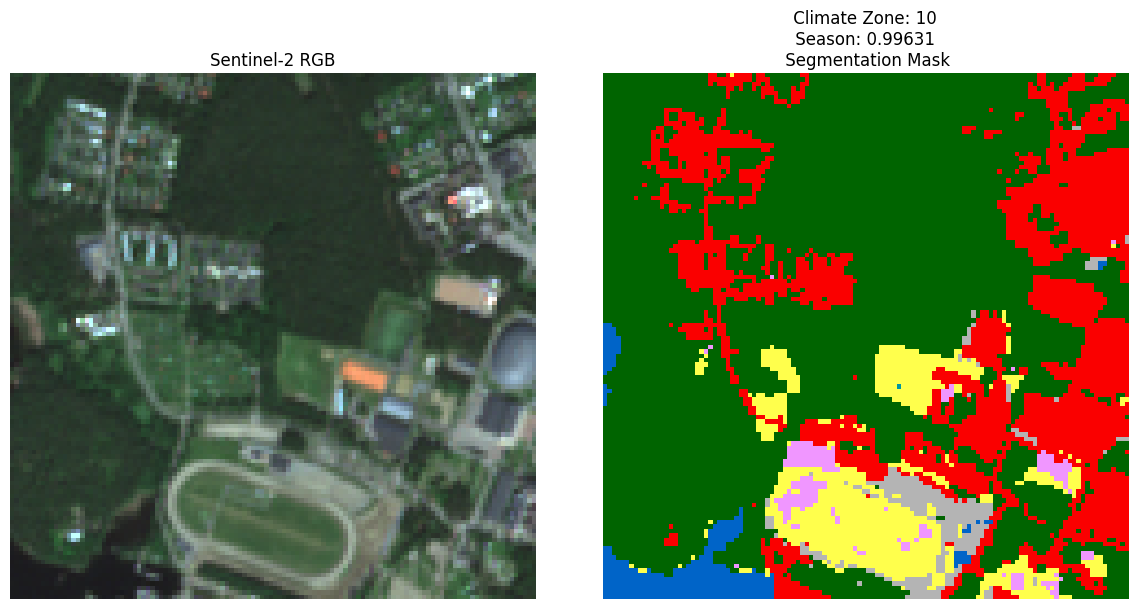

In [17]:
data_module.trainset.dataset.visualize_observation(10)

<a id='pretext'></a>
# Hand-crafted pre-text tasks
* Example from the remote sensing field: Geolocation prediction
* Labels are cheap: Every image is carries metadata with the geolocatin.

## Geolocation prediction
*Geography aware self-supervised learning*, ICCV 2021, Ayush et al.
1. Cluster dataset into $K$ clusters.
2. Assign categorical labels $c_i\in\mathbf{C}=\{1,...,K\}$ to the clusters.
3. Initialize geo-location predictor network $f_c$ as neural network.
4. Optimize with cross-entropy loss:
$$L_g=\sum_{k=1}^K -p(c_i=k)\log(\hat{p}(c_i=k|f_c(x_i^t))$$
where $p$ corresponds to the (binary) probability of cluster $k$ being the correct cluster, and $\hat{p}$ the predicted probability for cluster $k$.

In [18]:
# collect locations of all samples in the train set
locations = np.array([(s["lon"], s["lat"], s["geocluster"]) for s in tqdm(data_module.trainset, total=len(data_module.trainset))])
locations = np.array(locations)

100%|██████████| 600/600 [00:25<00:00, 23.80it/s]


In [21]:
# create interactivate map centered in Europe
ben_map = folium.Map(width=750,height=750, location=[50, 5], zoom_start=3)

# plot individual sample locations as markers
for idx, (lon,lat, cluster_idx) in enumerate(locations):
    folium.Marker(location=[lat, lon], icon=folium.Icon(color=folium_colors[int(cluster_idx)]), radius=3).add_to(ben_map)

# display the map
ben_map

In [22]:
class BENGETrainer(pl.LightningModule):
    def __init__(
        self,
        model,
        criterion,
        optimizer,
        scheduler,
        task="classification",
        classes=11,
        lr_scheduler=False,
    ):
        super().__init__()
        assert task in ["classification", "geocluster", "inpainting", "multi-modal-contrast"]
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.lr_scheduler = lr_scheduler
        self.task = task

        if self.task in ["classification", "geocluster", "multi-modal-contrast"]:
            self.train_metric = torchmetrics.Accuracy(task="multiclass", num_classes=classes)
            self.val_metric = torchmetrics.Accuracy(task="multiclass", num_classes=classes)
        elif self.task in ["inpainting", "mae"]:
            # regression
            self.train_metric = torchmetrics.MeanSquaredError()
            self.val_metric = torchmetrics.MeanSquaredError()

    def forward(self, img):
        return self.model(img)

    def configure_optimizers(self):
        if self.lr_scheduler:
            lr_scheduler_config = {
                "scheduler": self.scheduler,
                "interval": "epoch",
                "frequency": 1,
                "monitor": "val_loss",
                "strict": True,
                "name": None,
            }
            return {"optimizer": self.optimizer, "lr_scheduler": lr_scheduler_config}
        else:
            return self.optimizer

    def loss(self, pred, target):
        return self.criterion(pred, target)

    def get_target(self, batch):
        if self.task == "classification":
            y = batch["lulc_top"].squeeze().long()
        elif self.task == "geocluster":
            y = batch["geocluster"]
        elif self.task in ["inpainting", "multi-modal-contrast"]:
            # target is part of the input
            y = None
        elif self.task == "mae":
            y = batch["s2"]

        return y

    def get_data(self, batch):
        if len(batch) == 1:
            data = batch[0]
        elif self.task == "multi-modal-contrast":
            data = (batch["s2"], batch["s1"])
        else:
            data = batch["s2"]

        return data

    def training_step(self, train_batch, batch_idx):
        y = self.get_target(train_batch)
        data = self.get_data(train_batch)

        output = self.forward(data)

        if self.task == "inpainting":
            y, output = output
        elif self.task == "multi-modal-contrast":
            output, y = output

        train_metric = self.train_metric(output, y)
        train_loss = self.loss(output, y)

        stats = {
            "train_loss": train_loss.item(),
            "train_metric": train_metric.item(),
        }

        self.log_dict(stats, batch_size=y.shape[0], on_step=True, on_epoch=True, prog_bar=True)

        return train_loss

    def validation_step(self, val_batch, batch_idx):
        y = self.get_target(val_batch)
        data = self.get_data(val_batch)

        output = self.forward(data)

        if self.task == "inpainting":
            y, output = output
        elif self.task == "multi-modal-contrast":
            output, y = output

        val_metric = self.val_metric(output, y)
        val_loss = self.loss(output, y)

        stats = {
            "val_loss": val_loss.item(),
            "val_metric": val_metric.item(),
        }
        self.log_dict(stats, batch_size=y.shape[0], on_step=True, on_epoch=True, prog_bar=True)
        return val_loss

    def test_step(self, test_batch, batch_idx):
        y = self.get_target(test_batch)
        data = self.get_data(test_batch)

        output = self.forward(data)

        if self.task == "inpainting":
            y, output = output
        elif self.task == "multi-modal-contrast":
            output, y = output

        test_metric = self.val_metric(output, y)
        test_loss = self.loss(output, y)

        stats = {
            "test_loss": test_loss.item(),
            "test_metric": test_metric.item(),
        }
        self.log_dict(stats, batch_size=y.shape[0], on_step=True, on_epoch=True, prog_bar=True)
        return test_loss

In [23]:
# define device as GPU and initialize loss function
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
criterion = torch.nn.CrossEntropyLoss().to(device)

In [24]:
# create model
model = torchvision.models.resnet18(num_classes=20)

# adjust input layer for multi-spectral data
model.conv1 = torch.nn.Conv2d(12, 64, kernel_size=(7,7), stride=(3,3), bias=False)

# move model parameters to GPU
model.to(device)
f"created model on {model.conv1.weight.device}"

'created model on cuda:0'

In [25]:
# parameter optimization
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

# lightning training module
model_trainer = BENGETrainer(model, criterion, optimizer, scheduler, task="geocluster", classes=20)
metrics = MetricTracker()


trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=5,
    log_every_n_steps=1,
    accumulate_grad_batches=1,
    callbacks=([metrics]),
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [26]:
# train
trainer.fit(model_trainer, data_module.train_dataloader(), data_module.val_dataloader())

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | ResNet             | 11.2 M
1 | criterion    | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable pa

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


## Visualize training trajectory

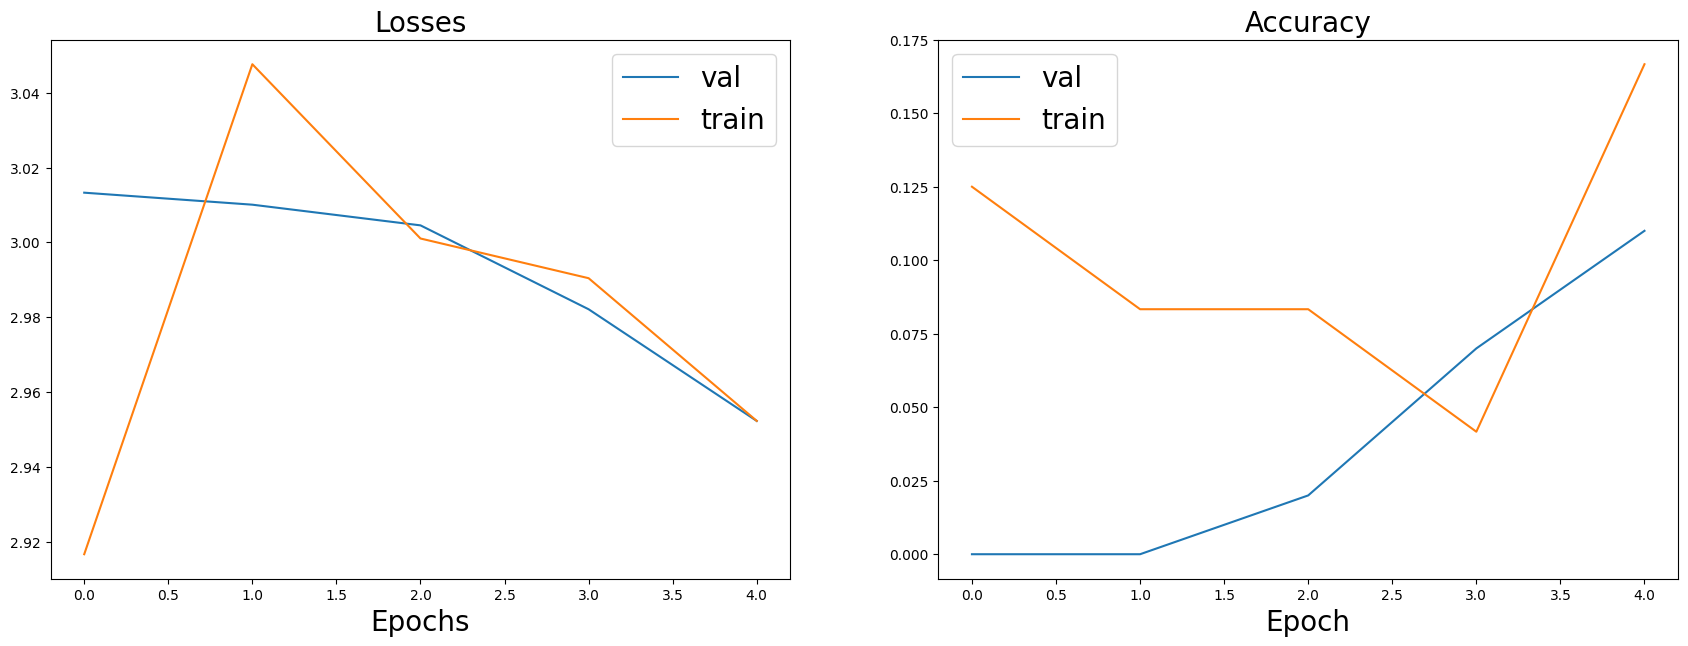

In [27]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(21, 7))

ax1.plot([m.item() for m in metrics.collection["val_loss_epoch"]][1:], label='val')
ax1.plot([m.item() for m in metrics.collection["train_loss"]], label='train')
ax1.set_xlabel('Epochs', fontsize=20)
ax1.set_title('Losses', fontsize=20)
ax1.legend(fontsize=20)

ax2.plot([m.item() for m in metrics.collection["val_metric_epoch"]][1:], label='val')
ax2.plot([m.item() for m in metrics.collection["train_metric"]], label='train')
ax2.set_xlabel('Epoch', fontsize=20)
ax2.set_title('Accuracy', fontsize=20)
ax2.legend(fontsize=20)

plt.show()

In [28]:
trainer.test(model_trainer, data_module.test_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    2.9080636501312256     │
│     test_metric_epoch     │    0.12999999523162842    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 2.9080636501312256,
  'test_metric_epoch': 0.12999999523162842}]

### After training on much more data...

In [29]:
# download the pre-trained checkpoint
!gdown 1QTRDS2vEccu3caDc3cml_s54JPko8Ee2

Downloading...
From: https://drive.google.com/uc?id=1QTRDS2vEccu3caDc3cml_s54JPko8Ee2
To: /content/geocluster_50ep_ben-ge-s.ckpt
100% 44.9M/44.9M [00:00<00:00, 133MB/s]


In [30]:
geocluster_state_dict = torch.load("geocluster_50ep_ben-ge-s.ckpt")["state_dict"]

# create model
# model = torchvision.models.resnet18(num_classes=20)

# adjust input layer for multi-spectral data
# model.conv1 = torch.nn.Conv2d(12, 64, kernel_size=(7,7), stride=(3,3), bias=False)

model.load_state_dict({k.replace("model.", "") : v for k,v in geocluster_state_dict.items()})

<All keys matched successfully>

In [31]:
trainer.test(model_trainer, data_module.test_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    1.4835295677185059     │
│     test_metric_epoch     │    0.5199999809265137     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 1.4835295677185059,
  'test_metric_epoch': 0.5199999809265137}]

In [32]:
# Geocluster prediction - evaluation on the test set
model.to(device)
model.eval()

test_accs = []
test_losses = []
with torch.no_grad():
    for sample in tqdm(data_module.test_dataloader()):
        img = sample["s2"].to(device)
        target = sample["geocluster"].to(device)

        y_hat = model(img)
        loss = criterion(y_hat, target)

        pred = y_hat.argmax(dim=1)
        acc = (pred == target).to(float).mean()

        test_accs.append(acc.item())
        test_losses.append(loss.item())

f"Test accuracy: {np.array(test_accs).mean():.3f}, loss: {np.array(test_losses).mean():.3f}"

100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


'Test accuracy: 0.522, loss: 1.485'

## Transfer to land cover classification
* The model works reasonably well for location prediction
* Let's see if this helps on a different task
* I.e., transfer learning from a self-supervised in-domain model

In [ ]:
# imagenet pretrained model
# model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

# randomly initialized model
# model = torchvision.models.resnet18(pretrained=False)
# model.conv1 = torch.nn.Conv2d(12, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)

In [33]:
# adjust final classification layer for the 11 landcover classes
model.fc = torch.nn.Linear(512, 11)

model.to(device)
"ready"

'ready'

In [34]:
criterion = torch.nn.CrossEntropyLoss().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_trainer = BENGETrainer(model, criterion, optimizer,scheduler=None, task="classification", classes=11)
metrics = MetricTracker()

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=5,
    log_every_n_steps=1,
    accumulate_grad_batches=1,
    callbacks=([metrics]),
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [35]:
trainer.fit(model_trainer, data_module.train_dataloader(), data_module.val_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params
----------------------------------------------------
0 | model        | ResNet             | 11.2 M
1 | criterion    | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
----------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.842    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


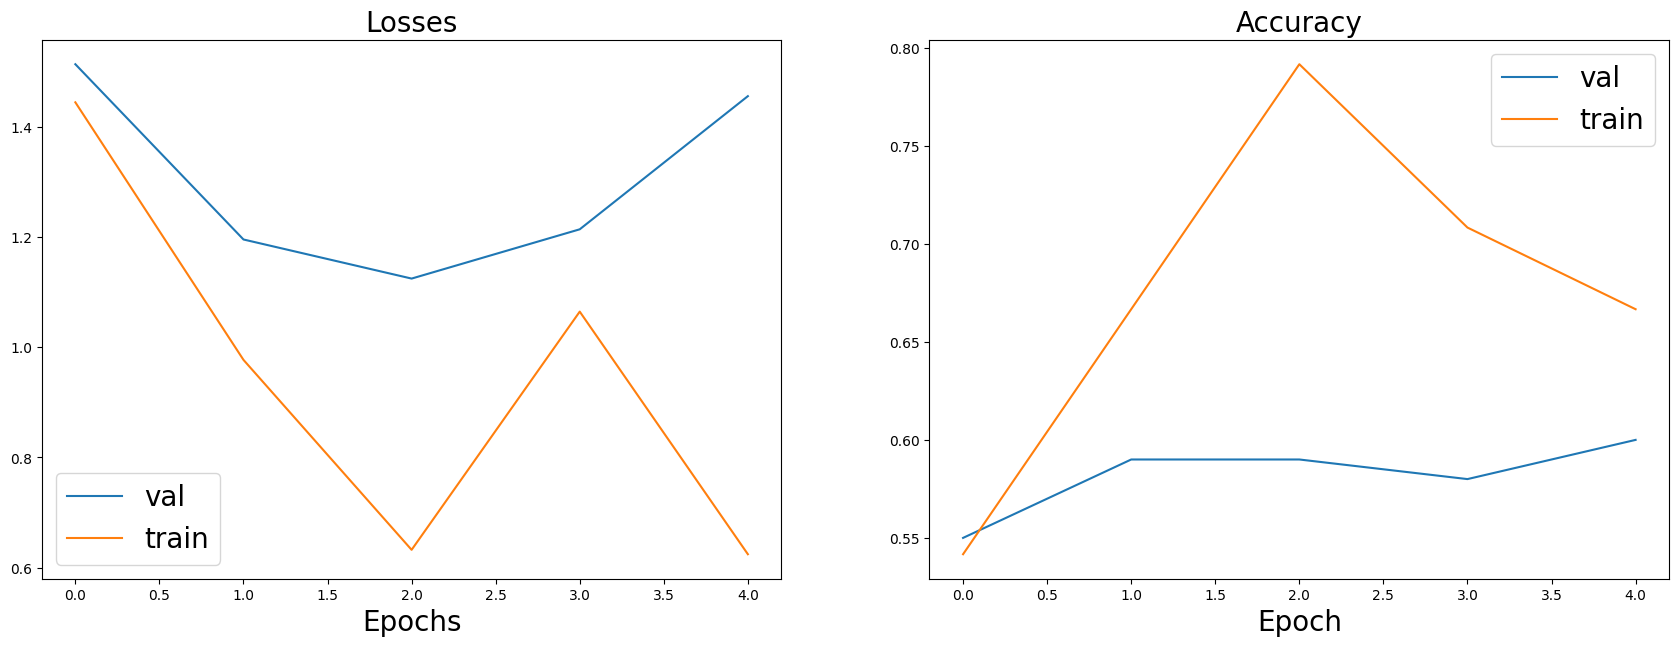

In [36]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(21, 7))

ax1.plot([m.item() for m in metrics.collection["val_loss_epoch"]][1:], label='val')
ax1.plot([m.item() for m in metrics.collection["train_loss"]], label='train')
ax1.set_xlabel('Epochs', fontsize=20)
ax1.set_title('Losses', fontsize=20)
ax1.legend(fontsize=20)

ax2.plot([m.item() for m in metrics.collection["val_metric_epoch"]][1:], label='val')
ax2.plot([m.item() for m in metrics.collection["train_metric"]], label='train')
ax2.set_xlabel('Epoch', fontsize=20)
ax2.set_title('Accuracy', fontsize=20)
ax2.legend(fontsize=20)

plt.show()

In [37]:
trainer.test(model_trainer, data_module.test_dataloader())

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    1.0251481533050537     │
│     test_metric_epoch     │    0.6600000262260437     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 1.0251481533050537,
  'test_metric_epoch': 0.6600000262260437}]

![image.png](attachment:77420b04-fff4-4aa7-9f22-1d5551cc3d1d.png)<img align="center" style="max-width: 1000px" src="https://github.com/HSG-AIML/IGARSS2023_EfficientDeepLearningEO/blob/main/04-ssl/context-encoders-overview.png?raw=1">

In [ ]:
class ChannelwiseFullyConnected(torch.nn.Module):
    def __init__(self, num_channels, map_size):
        super().__init__()
        self.num_channels = num_channels
        self.map_size = map_size
        self.fcs = [torch.nn.Linear(map_size, map_size) for _ in range(self.num_channels)]

    def forward(self, x):
        assert x.shape[1] == self.num_channels
        assert x.shape[2] * x.shape[3] == self.map_size

        return torch.stack([self.fcs[idx](x[:,idx]) for idx in range(self.num_channels)], dim=1)

In [ ]:
class ContextEncoder(torch.nn.Module):
    # encoder-decoder adapted from https://github.com/rll/deepul/blob/master/demos/lecture7_selfsupervised_demos.ipynb
    def __init__(self, num_channels=3, img_size=120):
        super().__init__()
        self.num_channels = num_channels
        self.img_size = img_size
        assert self.img_size <= 128
        self.latent_dim = 512
        pad_val = (128 - self.img_size) // 2
        self.pad = torchvision.transforms.Pad((pad_val, pad_val, pad_val, pad_val))
        self.encoder = torch.nn.Sequential(
            # 128 x 128 Input
            torch.nn.Conv2d(self.num_channels, 64, 4, stride=2, padding=1), # 64 x 64
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(64, 64, 4, stride=2, padding=1), # 32 x 32
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(64, 128, 4, stride=2, padding=1), # 16 x 16
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(128, 256, 4, stride=2, padding=1), # 8 x 8
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2, inplace=True),
            torch.nn.Conv2d(256, 512, 4, stride=2, padding=1), # 4 x 4
            # torch.nn.BatchNorm2d(512),
            # torch.nn.LeakyReLU(0.2, inplace=True),
            # torch.nn.Conv2d(512, self.latent_dim, 4) # 1 x 1
        )

        # self.bottleneck = CHannelwiseFullyConnected(self.latent_dim, 1)
        self.bottleneck = ChannelwiseFullyConnected(self.latent_dim, 4)

        self.decoder = torch.nn.Sequential(
            # torch.nn.BatchNorm2d(self.latent_dim),
            # torch.nn.ReLU(inplace=True),
            # torch.nn.ConvTranspose2d(self.latent_dim, 512, 4, stride=1, padding=0),
            torch.nn.BatchNorm2d(512),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.ReLU(inplace=True),
            torch.nn.ConvTranspose2d(64, self.num_channels, 4, stride=2, padding=1),
            torch.nn.Tanh()
        )

    def mask_center(self, x):
        assert x.shape[-1] == x.shape[-2], f"Image not square: {x.shape}"
        width = x.shape[-1]

        center = x[:, :, width//4 : width//4+width//2, width//4 : width//4+width//2].clone()

        masked = x.clone()
        masked[:, :, width//4 : width//4+width//2, width//4 : width//4+width//2] = 0

        return center, masked

    def forward(self, x):
        x = self.pad(x)
        center, masked = self.mask_center(x)
        z = self.encoder(masked)

        recon = self.decoder(z)

        return center, recon

In [ ]:
model = ContextEncoder(num_channels=12, img_size=120)
model.to(device)
"ready"

'ready'

In [ ]:
criterion = torch.nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_trainer = BENGETrainer(model, criterion, optimizer, None, task="inpainting")
metrics = MetricTracker()

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=5,
    log_every_n_steps=1,
    accumulate_grad_batches=1,
    callbacks=([metrics]),
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model_trainer, data_module.train_dataloader(), data_module.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | model        | ContextEncoder   | 5.6 M 
1 | criterion    | MSELoss          | 0     
2 | train_metric | MeanSquaredError | 0     
3 | val_metric   | MeanSquaredError | 0     
--------------------------------------------------
5.6 M     Trainable params
0         Non-trainable params
5.6 M     Total params
22.398    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

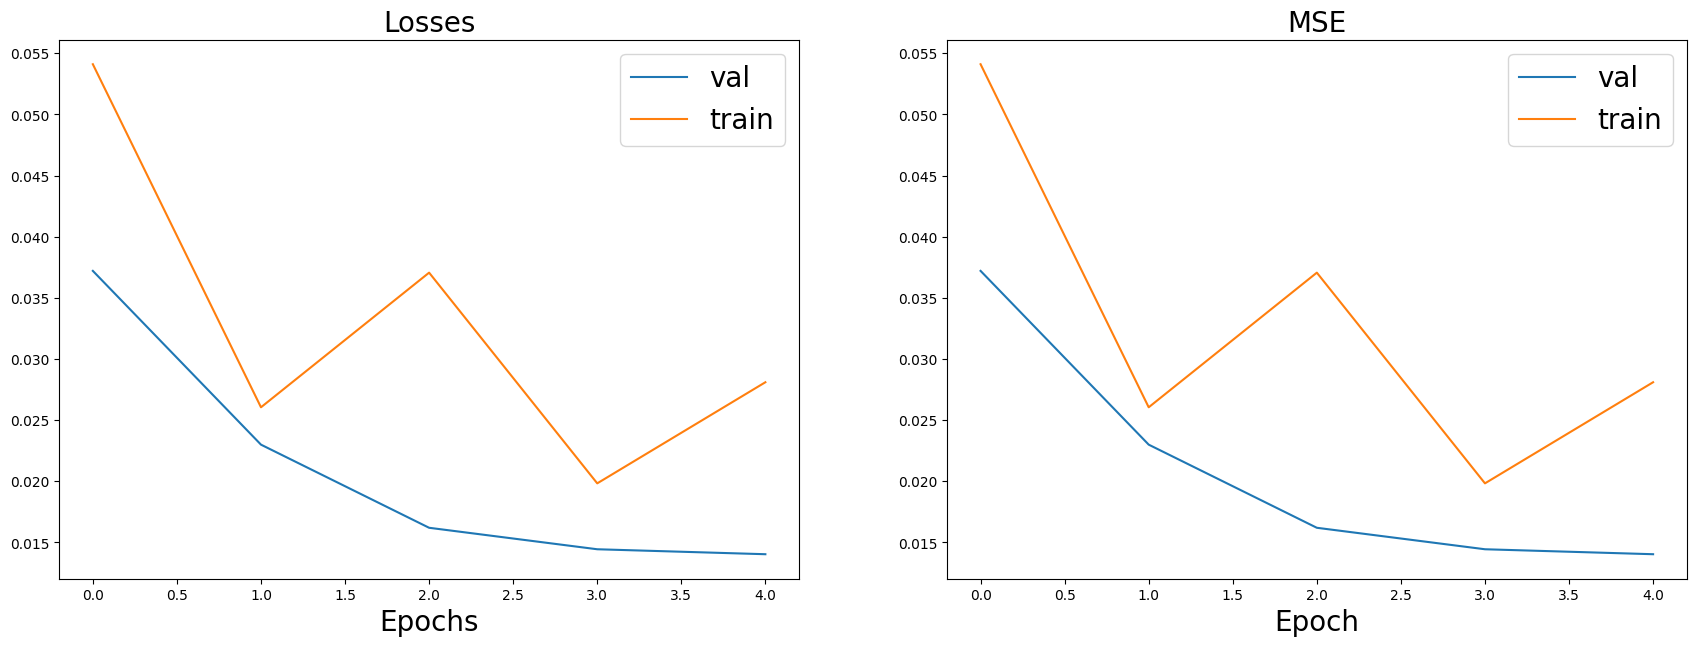

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(21, 7))

ax1.plot([m.item() for m in metrics.collection["val_loss_epoch"]][1:], label='val')
ax1.plot([m.item() for m in metrics.collection["train_loss"]], label='train')
ax1.set_xlabel('Epochs', fontsize=20)
ax1.set_title('Losses', fontsize=20)
ax1.legend(fontsize=20)

ax2.plot([m.item() for m in metrics.collection["val_metric_epoch"]][1:], label='val')
ax2.plot([m.item() for m in metrics.collection["train_metric"]], label='train')
ax2.set_xlabel('Epoch', fontsize=20)
ax2.set_title('MSE', fontsize=20)
ax2.legend(fontsize=20)

plt.show()

In [ ]:
# mask and re-create some samples

model.eval()
model.to(device)
pad = torchvision.transforms.Pad((4,4,4,4))

with torch.no_grad():
    imgs = []
    for idx,sample in enumerate(data_module.val_dataloader()):
        img_batch = sample["s2"].to(device)

        if idx == 5:
            break

    _, imgs_masked = model.mask_center(img_batch)
    img_center, img_recon = model(img_batch)

    imgs_combined = model.pad(imgs_masked.clone())
    width = img_batch.shape[-1] + 8
    imgs_combined[:, :, width//4 : width//4+width//2, width//4 : width//4+width//2] = img_recon.detach()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

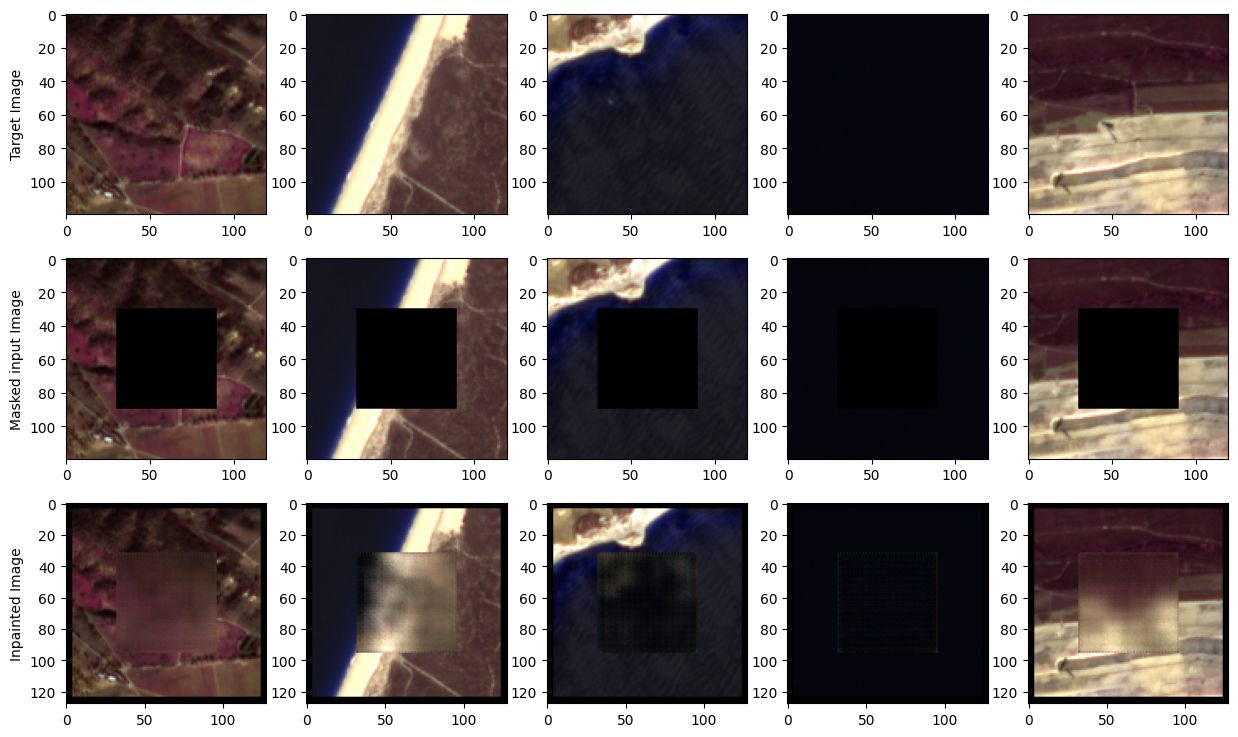

In [ ]:
fig, axs = plt.subplots(3, 5, figsize=(15, 9))

brightness = 3
for col in range(5):
    # for each image plot the original version, the masked version, and the reconstructed version
    axs[0, col].imshow(torch.moveaxis(img_batch[col].cpu(), 0, -1)[:, :, [4,3,2]] * brightness)
    axs[1, col].imshow(torch.moveaxis(imgs_masked[col].cpu(), 0, -1)[:, :, [4,3,2]] * brightness)
    axs[2, col].imshow(torch.moveaxis(imgs_combined[col].detach().cpu(), 0, -1)[:, :, [4,3,2]] * brightness)

axs[0,0].set_ylabel("Target Image")
axs[1,0].set_ylabel("Masked input Image")
axs[2,0].set_ylabel("Inpainted Image")
plt.show()

In [ ]:
# load pre-trained checkpoint
!gdown 1i-_Dwuk1qPrpUrRy9YLwJQVNmU1w3VwO

Downloading...
From (uriginal): https://drive.google.com/uc?id=1i-_Dwuk1qPrpUrRy9YLwJQVNmU1w3VwO
From (redirected): https://drive.google.com/uc?id=1i-_Dwuk1qPrpUrRy9YLwJQVNmU1w3VwO&confirm=t&uuid=6bb91ddd-e38c-40f9-9015-3f674f9e847f
To: /netscratch/lscheibenreif/code/igarss-tutorial/inpainting_50ep_ben-ge-800.ckpt
100%|███████████████████████████████████████| 67.3M/67.3M [00:00<00:00, 106MB/s]


In [ ]:
# Load pre-trained weights
if False:
    inpainting_state_dict = torch.load("inpainting_50ep_ben-ge-800.ckpt")["state_dict"]
    model.load_state_dict({k.replace("model.", "") : v for k,v in inpainting_state_dict.items()})
    model.to(device)
    print("weights loaded")

weights loaded


<a id='contrast'></a>
# Contrastive Learning
* Goal: learn data representations by comparing individual samples
* Similar samples should be close in representation space
* Dissimilar samples should be far apart

This is the general idea of contrastive learning.


<img align="center" style="max-width: 500px" src="https://github.com/HSG-AIML/IGARSS2023_EfficientDeepLearningEO/blob/main/04-ssl/simclr-overview.png?raw=1">

**A Simple Framework for Contrastive Learning of Visual Representations**, Chen et al.
* Similar datapoints are different views of the same object
* Views are artificially generated through image augmentations

<img align="center" style="max-width: 800px" src="https://github.com/HSG-AIML/IGARSS2023_EfficientDeepLearningEO/blob/main/04-ssl/simclr-augment.png?raw=1">

* For a mini-batch of n sampels, we have 2n augmented images.
* Given a positive pair, the other 2(n-1) samples are treated as the negative samples.
* The similarity is given as dot product between the normalized feature vectors
* For a positive pair $i,j$:

<img align="center" style="max-width: 400px" src="https://github.com/HSG-AIML/IGARSS2023_EfficientDeepLearningEO/blob/main/04-ssl/simclr-loss.png?raw=1">

<img align="center" style="max-width: 800px" src="https://github.com/HSG-AIML/IGARSS2023_EfficientDeepLearningEO/blob/main/04-ssl/contrastive-learning.png?raw=1">

In [ ]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, n_views=2, temp=0.1):
        super().__init__()
        self.n_views = n_views
        self.temp = temp

    def __call__(self, features):
        # adapted from https://github.com/sthalles/SimCLR/

        batch_size = features.shape[0] // 2
        device = features.device

        # 2*batch_size, 2*batch_size with 1 on diagonal and on on diagonal of top and bottom half
        labels = torch.cat([torch.arange(batch_size) for i in range(self.n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(device)

        # normalize the features
        features = torch.nn.functional.normalize(features, dim=1)

        # compute similarity between features as dot product
        similarity_matrix = torch.matmul(features, features.T)

        # discard the main diagonal from both: labels and similarities matrix
        # self-similarity of samples
        mask = torch.eye(labels.shape[0], dtype=bool).to(device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

        # select and combine multiple positives
        # positives = on diag of top right bottom left quadrants
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(device)

        logits = logits / self.temp

        #loss = torch.nn.functional.cross_entropy(logits, labels)

        return logits, labels

<a id='multi-modal'></a>
# Multi-modal Contrast
* Multiple views might be naturally available
* In remote sensing from overflights at different times
* And/or from different sensors

**Idea:** Use co-located Sentinel-1/2 images for contrastive learning

<img align="center" style="max-width: 500px" src="https://github.com/HSG-AIML/IGARSS2023_EfficientDeepLearningEO/blob/main/04-ssl/multi-modal-contrast.png?raw=1">

In [ ]:
data_module = BENGEDataModule()
data_module.setup(
    data_base_path,
    train_batch_size,
    eval_batch_size,
    drop_last=True,
)

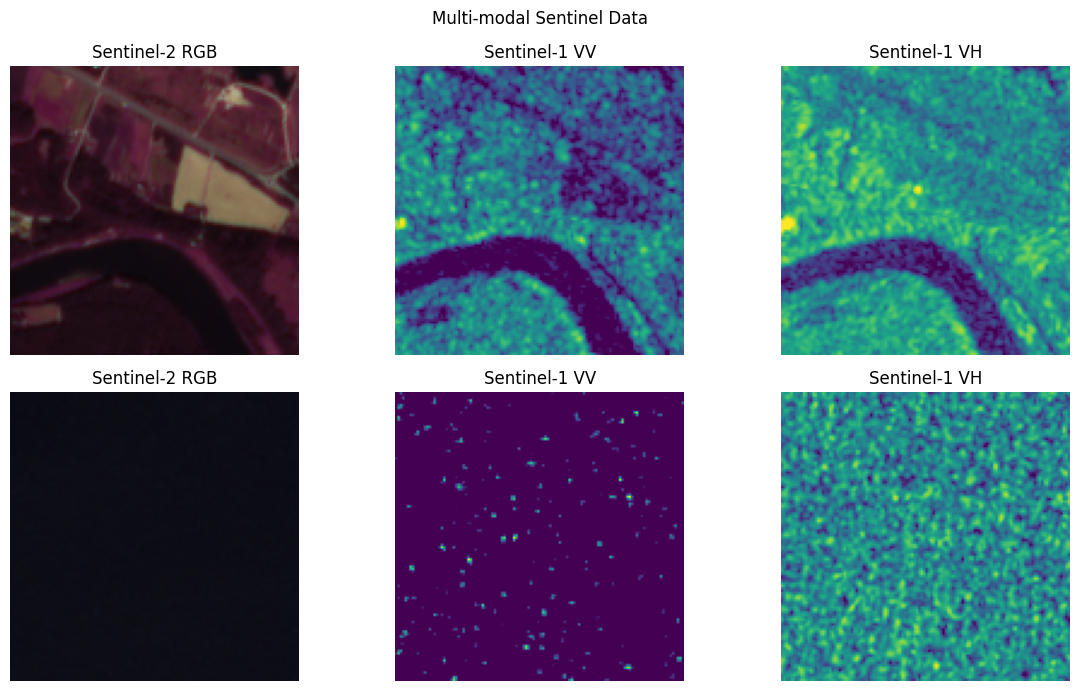

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(12,7))

for sample_idx, row in enumerate(axs):
    sample = data_module.trainset[sample_idx]
    row[0].imshow(torch.moveaxis(sample["s2"][[4,3,2], :, :], 0, -1) * 3)
    row[0].set_title("Sentinel-2 RGB")
    row[1].imshow(sample["s1"][0])
    row[1].set_title("Sentinel-1 VV")
    row[2].imshow(sample["s1"][1])
    row[2].set_title("Sentinel-1 VH")

for ax in axs.flatten():
    ax.axis(False)

plt.suptitle("Multi-modal Sentinel Data")

plt.tight_layout()
plt.show()

In [ ]:
# model with two encoders, one for each modality
class DualEncoder(torch.nn.Module):
    def __init__(self, num_s2_channels, num_s1_channels, latent_dim=256):
        super().__init__()
        self.num_s2_channels = num_s2_channels
        self.num_s1_channels = num_s1_channels
        self.projector = torch.nn.Sequential(torch.nn.Linear(512, 512), torch.nn.ReLU(), torch.nn.Linear(512, 256))

        self.s2_encoder = torchvision.models.resnet18()
        self.s2_encoder.conv1 = torch.nn.Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # self.s2_encoder.fc = torch.nn.Sequential(torch.nn.Linear(512, 512), torch.nn.ReLU(), torch.nn.Linear(512, 256))
        self.s2_encoder.fc = self.projector

        self.s1_encoder = torchvision.models.resnet18()
        self.s1_encoder.conv1 = torch.nn.Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # self.s1_encoder.fc = torch.nn.Sequential(torch.nn.Linear(512, 512), torch.nn.ReLU(), torch.nn.Linear(512, 256))
        self.s1_encoder.fc = self.projector

        self.contrastive_loss = ContrastiveLoss()

    def forward(self, data):
        s2, s1 = data
        features = torch.concat((self.s2_encoder(s2), self.s1_encoder(s1)))
        logits, labels = self.contrastive_loss(features)
        return logits, labels


model = DualEncoder(12, 2)
model.to(torch.device("cuda"))
"ready"

'ready'

In [ ]:
# criterion = ContrastiveLoss().to(device)
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_trainer = BENGETrainer(model, criterion, optimizer, None, classes=2*train_batch_size-1, task="multi-modal-contrast")
metrics = MetricTracker()

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=5,
    log_every_n_steps=1,
    accumulate_grad_batches=1,
    callbacks=([metrics]),
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model_trainer, data_module.train_dataloader(), data_module.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params
----------------------------------------------------
0 | model        | DualEncoder        | 22.8 M
1 | criterion    | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
----------------------------------------------------
22.8 M    Trainable params
0         Non-trainable params
22.8 M    Total params
91.088    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

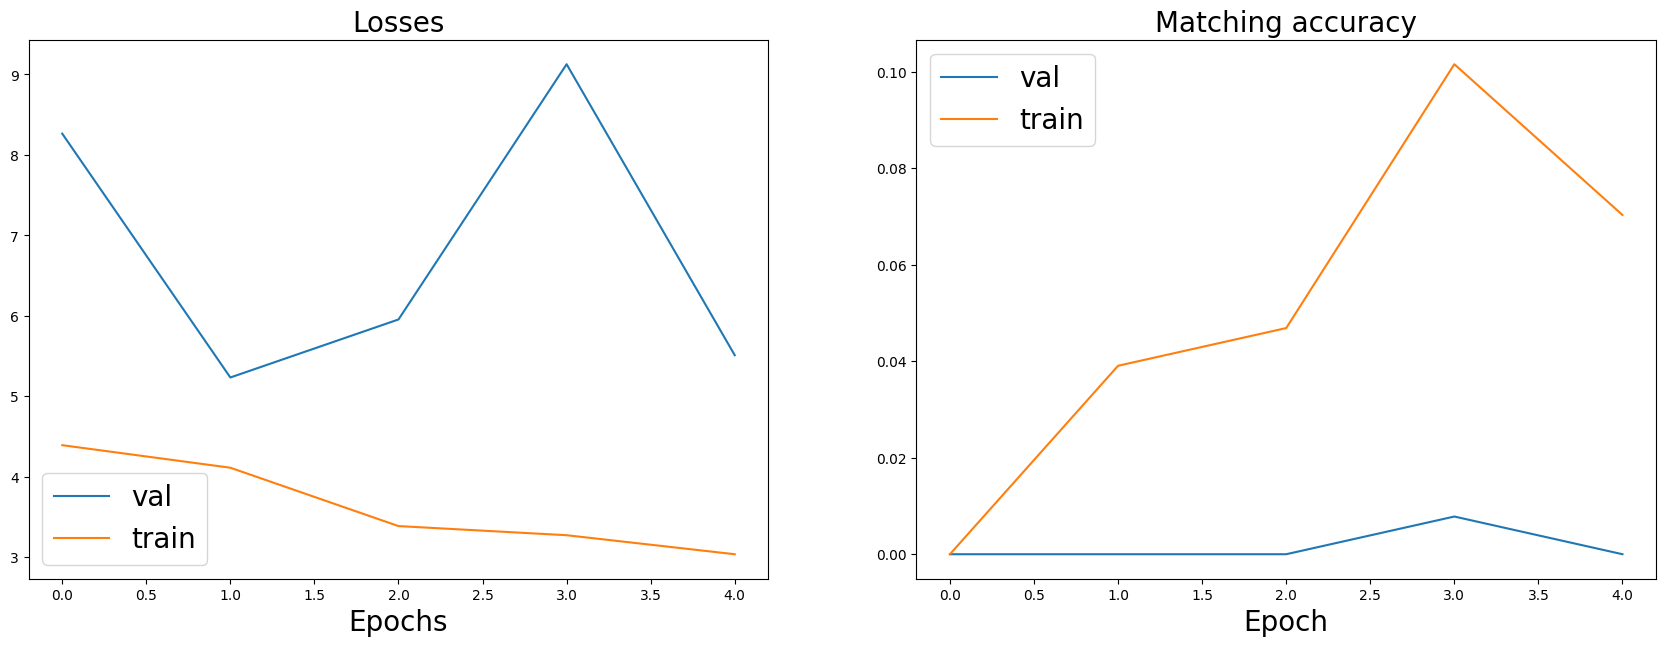

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(21, 7))

ax1.plot([m.item() for m in metrics.collection["val_loss_epoch"]][1:], label='val')
ax1.plot([m.item() for m in metrics.collection["train_loss"]], label='train')
ax1.set_xlabel('Epochs', fontsize=20)
ax1.set_title('Losses', fontsize=20)
ax1.legend(fontsize=20)

ax2.plot([m.item() for m in metrics.collection["val_metric_epoch"]][1:], label='val')
ax2.plot([m.item() for m in metrics.collection["train_metric"]], label='train')
ax2.set_xlabel('Epoch', fontsize=20)
ax2.set_title('Matching accuracy', fontsize=20)
ax2.legend(fontsize=20)

plt.show()

## Pre-trained model
* [Self-supervised vision transformers for land-cover segmentation and classification](https://openaccess.thecvf.com/content/CVPR2022W/EarthVision/papers/Scheibenreif_Self-Supervised_Vision_Transformers_for_Land-Cover_Segmentation_and_Classification_CVPRW_2022_paper.pdf) CVPRW EarthVision 2022
* [Codebase](https://github.com/HSG-AIML/SSLTransformerRS)

In [ ]:
!gdown 1vbj9WVK-MZNuAJGEOGEvE663b9BUwPSh -O multi-modal-contrast-resnet18.ckpt

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vbj9WVK-MZNuAJGEOGEvE663b9BUwPSh
From (redirected): https://drive.google.com/uc?id=1vbj9WVK-MZNuAJGEOGEvE663b9BUwPSh&confirm=t&uuid=dadcfdc0-fcf5-4e0b-a62b-18c1724b8b10
To: /netscratch/lscheibenreif/code/igarss-tutorial/multi-modal-contrast-resnet18.ckpt
100%|█████████████████████████████████████████| 277M/277M [00:02<00:00, 131MB/s]


In [ ]:
# load checkpoint and extract weights of Sentinel-2 encoder
checkpoint = torch.load("multi-modal-contrast-resnet18.ckpt")
state_dict = checkpoint["state_dict"]
s2_encoder_state = {k.replace("backbone2.", "") : v for k,v in state_dict.items() if "backbone2" in k}

In [ ]:
# create model instance
s2_encoder = torchvision.models.resnet18(num_classes=11)
s2_encoder.conv1 = torch.nn.Conv2d(13, 64, kernel_size=(7,7), stride=(3,3), bias=False)

In [ ]:
# load the encoder but not the projection head - classification layer is randomly initialized for land-cover classification
missing, unexpected = s2_encoder.load_state_dict(s2_encoder_state, strict=False)
f"{missing=}, {unexpected=}"

"missing=['fc.weight', 'fc.bias'], unexpected=['fc.0.weight', 'fc.0.bias', 'fc.2.weight', 'fc.2.bias']"

In [ ]:
for k,v in s2_encoder.named_parameters():
    # print(k, v.requires_grad)
    if k not in ["fc.bias", "fc.weight"]:
        v.requires_grad = False

In [ ]:
data_module = BENGEDataModule()
data_module.setup(
    data_base_path,
    32,
    32,
    add_dummy_band=True,
    drop_last=True,
)

In [ ]:
criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(s2_encoder.parameters(), lr=learning_rate)

model_trainer = BENGETrainer(s2_encoder, criterion, optimizer, None, classes=11, task="classification")
metrics = MetricTracker()

trainer = pl.Trainer(
    accelerator='gpu',
    devices=1,
    max_epochs=5,
    log_every_n_steps=1,
    accumulate_grad_batches=1,
    callbacks=([metrics]),
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model_trainer, data_module.train_dataloader(), data_module.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type               | Params
----------------------------------------------------
0 | model        | ResNet             | 11.2 M
1 | criterion    | CrossEntropyLoss   | 0     
2 | train_metric | MulticlassAccuracy | 0     
3 | val_metric   | MulticlassAccuracy | 0     
----------------------------------------------------
5.6 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.854    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

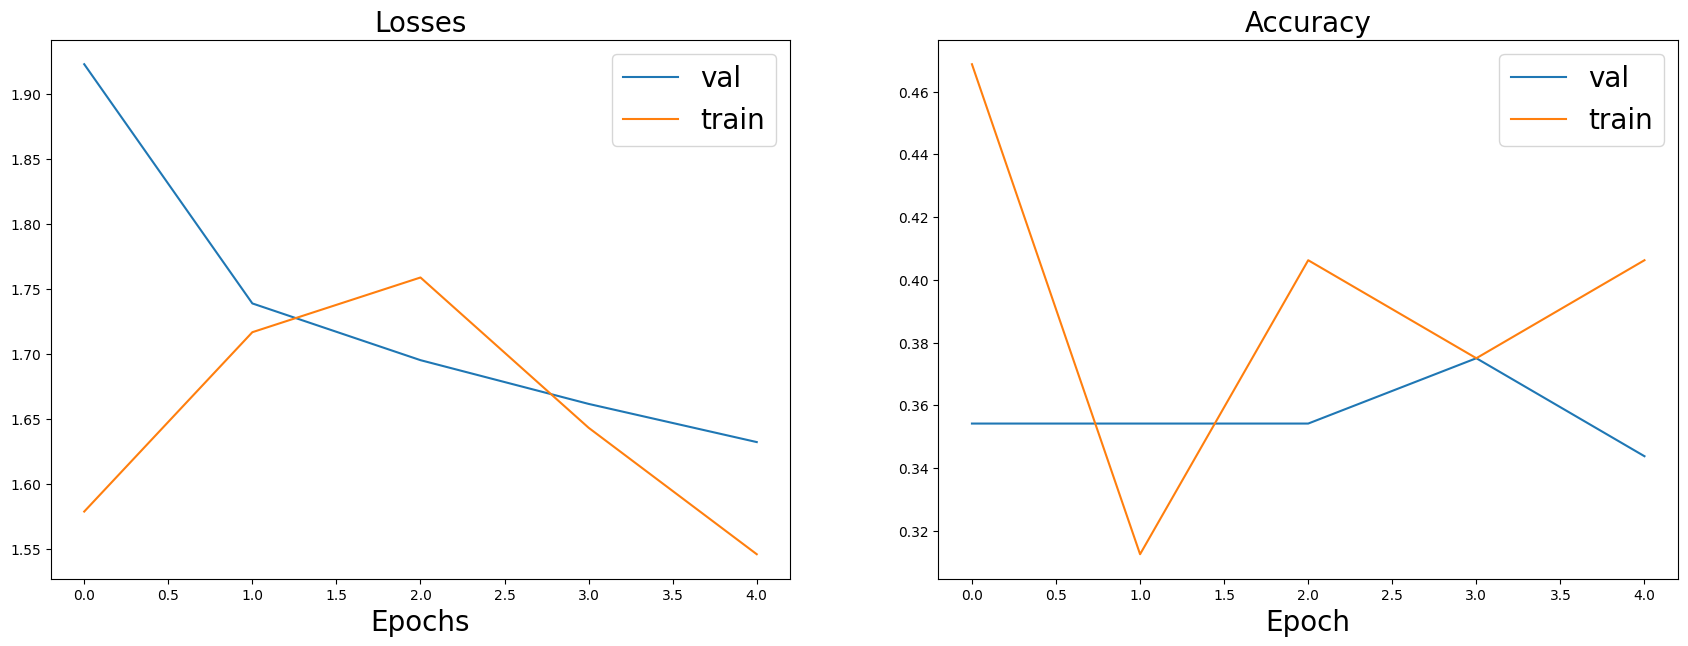

In [ ]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(21, 7))

ax1.plot([m.item() for m in metrics.collection["val_loss_epoch"]][1:], label='val')
ax1.plot([m.item() for m in metrics.collection["train_loss"]], label='train')
ax1.set_xlabel('Epochs', fontsize=20)
ax1.set_title('Losses', fontsize=20)
ax1.legend(fontsize=20)

ax2.plot([m.item() for m in metrics.collection["val_metric_epoch"]][1:], label='val')
ax2.plot([m.item() for m in metrics.collection["train_metric"]], label='train')
ax2.set_xlabel('Epoch', fontsize=20)
ax2.set_title('Accuracy', fontsize=20)
ax2.legend(fontsize=20)

plt.show()

In [ ]:
trainer.test(model_trainer, data_module.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_loss_epoch      │    1.4510358572006226     │
│     test_metric_epoch     │          0.4375           │
└───────────────────────────┴───────────────────────────┘

[{'test_loss_epoch': 1.4510358572006226, 'test_metric_epoch': 0.4375}]

<a id='mae'></a>
# Masked Autoencoding

## Transformers
* Reference implementations of many transformer methods: [vit_pytorch](https://github.com/lucidrains/vit-pytorch)

<img align="center" style="max-width: 800px" src="https://github.com/HSG-AIML/IGARSS2023_EfficientDeepLearningEO/blob/main/04-ssl/vit-overview.png?raw=1">

In [ ]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))
    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

# Masked Autoencoders
<img align="center" style="max-width: 500px" src="https://github.com/HSG-AIML/IGARSS2023_EfficientDeepLearningEO/blob/main/04-ssl/mae-overview.png?raw=1">

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from einops import repeat

class MAE(nn.Module):
    def __init__(
        self,
        *,
        encoder,
        decoder_dim,
        masking_ratio = 0.75,
        decoder_depth = 1,
        decoder_heads = 8,
        decoder_dim_head = 64
    ):
        super().__init__()
        assert masking_ratio > 0 and masking_ratio < 1, 'masking ratio must be kept between 0 and 1'
        self.masking_ratio = masking_ratio

        # extract some hyperparameters and functions from encoder (vision transformer to be trained)
        self.encoder = encoder
        num_patches, encoder_dim = encoder.pos_embedding.shape[-2:]

        self.to_patch = encoder.to_patch_embedding[0]
        self.patch_to_emb = nn.Sequential(*encoder.to_patch_embedding[1:])

        pixel_values_per_patch = encoder.to_patch_embedding[2].weight.shape[-1]

        # decoder parameters
        self.decoder_dim = decoder_dim
        self.enc_to_dec = nn.Linear(encoder_dim, decoder_dim) if encoder_dim != decoder_dim else nn.Identity()
        self.mask_token = nn.Parameter(torch.randn(decoder_dim))
        self.decoder = Transformer(dim = decoder_dim, depth = decoder_depth, heads = decoder_heads, dim_head = decoder_dim_head, mlp_dim = decoder_dim * 4)
        self.decoder_pos_emb = nn.Embedding(num_patches, decoder_dim)
        self.to_pixels = nn.Linear(decoder_dim, pixel_values_per_patch)

    def forward(self, img):
        device = img.device

        # get patches
        patches = self.to_patch(img)
        batch, num_patches, *_ = patches.shape

        # patch to encoder tokens and add positions
        tokens = self.patch_to_emb(patches)
        tokens = tokens + self.encoder.pos_embedding[:, 1:(num_patches + 1)]

        # calculate of patches needed to be masked, and get random indices, dividing it up for mask vs unmasked
        num_masked = int(self.masking_ratio * num_patches)
        rand_indices = torch.rand(batch, num_patches, device = device).argsort(dim = -1)
        masked_indices, unmasked_indices = rand_indices[:, :num_masked], rand_indices[:, num_masked:]

        # get the unmasked tokens to be encoded
        batch_range = torch.arange(batch, device = device)[:, None]
        tokens = tokens[batch_range, unmasked_indices]

        # get the patches to be masked for the final reconstruction loss
        masked_patches = patches[batch_range, masked_indices]

        # attend with vision transformer
        encoded_tokens = self.encoder.transformer(tokens)

        # project encoder to decoder dimensions, if they are not equal - the paper says you can get away with a smaller dimension for decoder
        decoder_tokens = self.enc_to_dec(encoded_tokens)

        # reapply decoder position embedding to unmasked tokens
        unmasked_decoder_tokens = decoder_tokens + self.decoder_pos_emb(unmasked_indices)

        # repeat mask tokens for number of masked, and add the positions using the masked indices derived above
        mask_tokens = repeat(self.mask_token, 'd -> b n d', b = batch, n = num_masked)
        mask_tokens = mask_tokens + self.decoder_pos_emb(masked_indices)

        # concat the masked tokens to the decoder tokens and attend with decoder
        decoder_tokens = torch.zeros(batch, num_patches, self.decoder_dim, device=device)
        decoder_tokens[batch_range, unmasked_indices] = unmasked_decoder_tokens
        decoder_tokens[batch_range, masked_indices] = mask_tokens
        decoded_tokens = self.decoder(decoder_tokens)

        # splice out the mask tokens and project to pixel values
        mask_tokens = decoded_tokens[batch_range, masked_indices]
        pred_pixel_values = self.to_pixels(mask_tokens)

        # calculate reconstruction loss
        recon_loss = F.mse_loss(pred_pixel_values, masked_patches)
        return recon_loss

In [ ]:
v = ViT(
    image_size = 120,
    channels=12,
    patch_size = 12,
    num_classes = 11,
    dim = 256,
    depth = 4,
    heads = 4,
    mlp_dim = 512
)

mae = MAE(
    encoder = v,
    masking_ratio = 0.75,   # the paper recommended 75% masked patches
    decoder_dim = 512,      # paper showed good results with just 512
    decoder_depth = 6       # anywhere from 1 to 8
)

In [ ]:
loss = mae(torch.randn(1, 12, 120, 120))

<a id='conclusion'></a>
# Conclusion

* Self-supervised learning
* Transfer learning on downstream tasks
* Fine-tuning vs. linear probing

# Questions?